In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

In [3]:
ibc_df.head()

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448


In [4]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [5]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})



In [6]:
def simulate_ibc(true_z, texp, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp, mej, fni, vej])

    
    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'texp': texp, 'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(ibc_obs, arnett_model, [params])
    
    r_band_mask = lcs[0]['band'] == 'lsstr'

    
    # calculate SNR in r band
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)
    # mej = (mej * u.Msun).to(u.g)
    # vej = vej * u.km/u.s
    # opac = 0.1 *u.cm * u.cm/u.g        

    # Diffusion timescale in days
    # td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
    # print(td)
    # lcs[0]['flux'][lcs[0]['flux'] <= 0] = 0.1
    return lcs

SNR: 1.4130674205239802


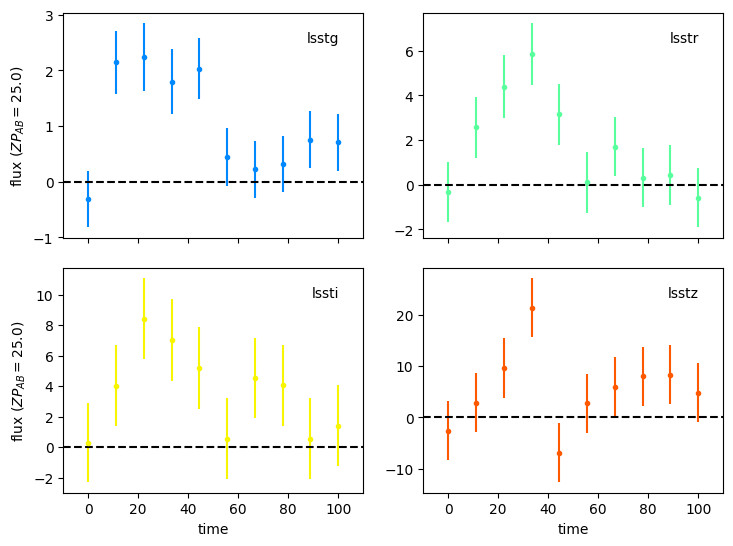

In [7]:
# light_curve = simulate_ibc(0.05, 0, 3, 0.1, 10000)
# light_curve = simulate_ibc(0.116, 5.76, 0.4841, 0.0309, 37270.73384139233)
# light_curve = simulate_ibc(0.116, 2.4, 0.4841, 0.0309, 37270.73384139233)

light_curve = simulate_ibc(0.18, 0, 5.4863 , 0.0456, 10416.298485236222)


sncosmo.plot_lc(light_curve[0]);

In [8]:
times

array([  0.1       ,   1.10909091,   2.11818182,   3.12727273,
         4.13636364,   5.14545455,   6.15454545,   7.16363636,
         8.17272727,   9.18181818,  10.19090909,  11.2       ,
        12.20909091,  13.21818182,  14.22727273,  15.23636364,
        16.24545455,  17.25454545,  18.26363636,  19.27272727,
        20.28181818,  21.29090909,  22.3       ,  23.30909091,
        24.31818182,  25.32727273,  26.33636364,  27.34545455,
        28.35454545,  29.36363636,  30.37272727,  31.38181818,
        32.39090909,  33.4       ,  34.40909091,  35.41818182,
        36.42727273,  37.43636364,  38.44545455,  39.45454545,
        40.46363636,  41.47272727,  42.48181818,  43.49090909,
        44.5       ,  45.50909091,  46.51818182,  47.52727273,
        48.53636364,  49.54545455,  50.55454545,  51.56363636,
        52.57272727,  53.58181818,  54.59090909,  55.6       ,
        56.60909091,  57.61818182,  58.62727273,  59.63636364,
        60.64545455,  61.65454545,  62.66363636,  63.67

In [9]:
def get_texp_guess(light_curve):
    max_index = np.argmax(light_curve[0]['flux'][light_curve[0]['band'] == 'lssti'])
    print(max_index)
    max_time = (light_curve[0]['time'][light_curve[0]['band'] == 'lssti'])[max_index]
    print((light_curve[0]['time'][light_curve[0]['band'] == 'lssti']))
    print(max_time)
    return max_time - 5.

In [10]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [11]:
def td(mej, vej):
    mej = (mej * u.Msun).to(u.g)
    vej = vej * u.km/u.s
    # Diffusion timescale in days
    opac = 0.1 *u.cm * u.cm/u.g        
    td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day) 
    return td

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...


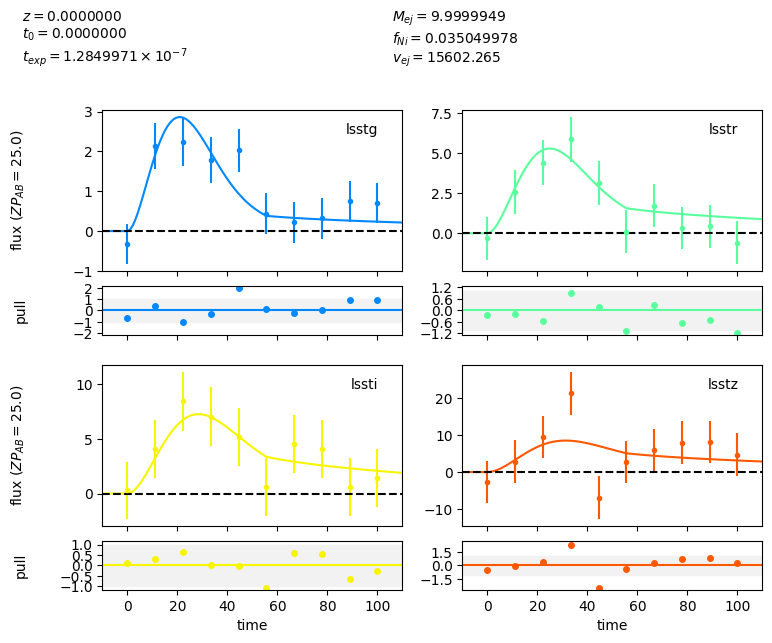

In [12]:
result, fitted_model = fit_ibc(0.18, light_curve)
sncosmo.plot_lc(light_curve[0], model=fitted_model);

In [13]:
num_to_fit = 10
fits = {'true_z': [], 'true_texp': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_texp':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    this_texp = np.random.uniform(0., 7.)
    # if true_z > 0.2 or vej.value > 20000:
    #     continue
    
    print(true_z, this_texp)

    print(mej, fni, vej)
    try:
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej.value)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("SNR too low:", peak_snr)
            continue
        # sncosmo.plot_lc(lcs[0])

        result, fitted_model = fit_ibc(true_z, lcs)
        # sncosmo.plot_lc(lcs[0], model=fitted_model)
        # plt.show()
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_texp'].append(this_texp)
        fits['true_mej'].append(mej)
        fits['true_fni'].append(fni)
        fits['true_vej'].append(vej.value)
        fits['fit_texp'].append(result_dict['texp'])
        fits['fit_mej'].append(result_dict['mej'])
        fits['fit_fni'].append(result_dict['fni'])
        fits['fit_vej'].append(result_dict['vej'])
    except Exception as e:
        print(e)

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.621 6.392569883837663
4.046 0.0744 5748.580347068582 km / s
SNR: 0.7463413174280679
SNR too low: 1.7529711429646957
0.309 6.3960780613094
6.1297 0.0565 6364.035693094851 km / s
SNR: 1.3499460032572077
SNR too low: 3.099951224868297
0.817 6.458778003962654
9.8119 0.0849 6533.973178945778 km / s
SNR: 0.7926547725662826
SNR too low: 2.136719946055284
0.586 5.710654234557074
1.1125 0.0801 25485.974243842764 km / s
SNR: 0.46569157875179634
SNR too low: 1.0661371871653489
0.441 0.7901675881492627
2.0126 0.0448 13163.162093340352 km / s
SNR: 0.7268031634942564
SNR too low: 1.0177365860199226
0.789 1.548384433868351
7.9452 0.1443 7627.722958615932 km / s
SNR: 0.7560570017399971
SNR too low: 1.5562675414010836
0.228 2.450937559914207
4.5871 0.0931 8095.727773637579 km / s
SNR: 1.4214403795584483
SNR too low: 3.830548479585291
0.861 4.097866647402967
6.7104 0.1127 10015.866271790786 km / s
SNR: 1.1430683591650455
SNR too low: 2.11071720559826
0.419 6.3482335006170985
6.2047 0.0218 6066.1700043

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


SNR: 1.0378810269356769
SNR too low: 2.390133922675882
0.557 3.430042574615644
1.4312 0.0912 21563.022057158636 km / s
SNR: 0.5099067380776484
SNR too low: 0.6232384953956784
0.644 1.620374937247854
1.2606 0.0973 18159.81198571986 km / s
SNR: 0.8273230390128734
SNR too low: 1.2053971697785868
0.535 3.1673261915450106
7.2421 0.107 6331.411178633044 km / s
SNR: 0.9962278553285031
SNR too low: 1.9250291471206566
0.095 1.0506653930259786
2.5761 0.0146 15028.819140533313 km / s
SNR: 1.2421598356813257
SNR too low: 2.6000266226217974
0.406 6.77517808270789
8.772 0.0175 8089.052273572769 km / s
SNR: 1.181936577570884
SNR too low: 2.0083015300707747
0.571 2.4533565448163204
6.5121 0.0523 9367.865820614776 km / s
SNR: 0.7062175371189222
SNR too low: 1.5519092959697327
0.473 1.14103048175046
8.0642 0.0244 5497.182813854847 km / s
SNR: 0.6598930128301383
SNR too low: 1.6286710987744784
0.404 1.9577691337908523
4.0871 0.0574 12247.225180940191 km / s
SNR: 0.788457707084264
SNR too low: 1.689435732

Text(0, 0.5, 'Fit texp')

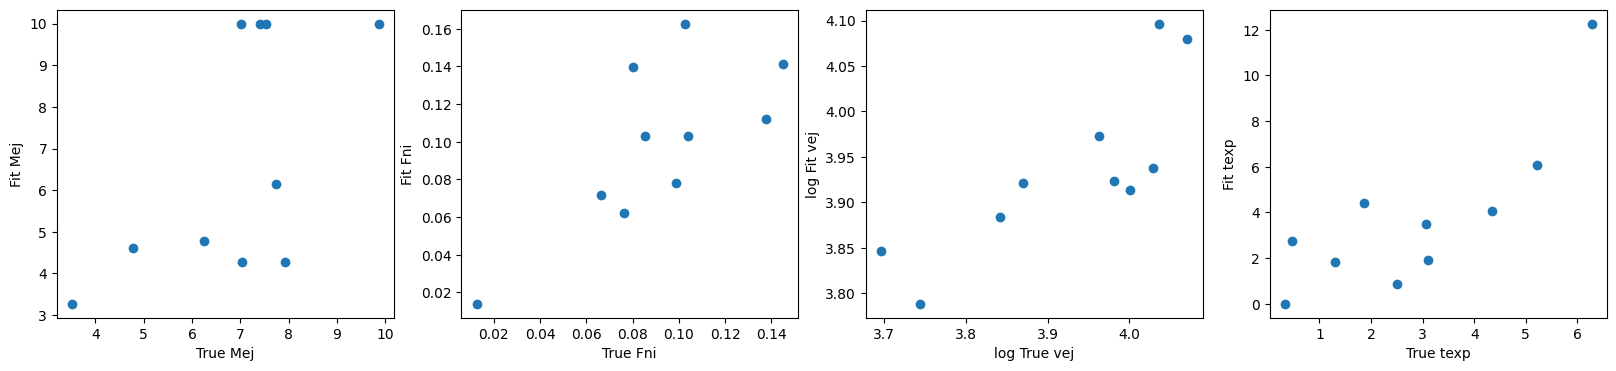

In [14]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")
ax[3].plot(fits['true_texp'], fits['fit_texp'], 'o')
ax[3].set_xlabel("True texp")
ax[3].set_ylabel("Fit texp")

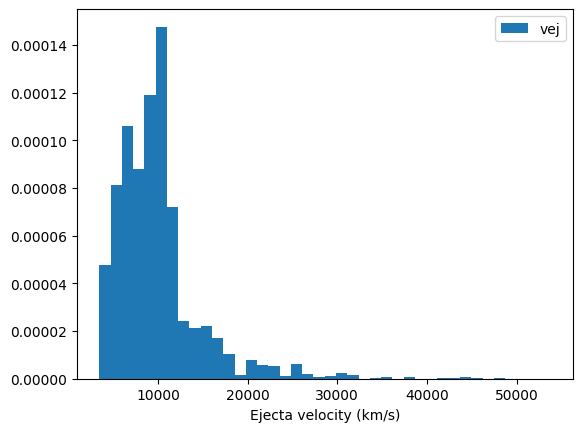

In [15]:
vej = np.sqrt(
    2 * ibc_df['Kinetic_energy'].values * 1e51 * u.erg / (ibc_df['Mejecta'].values * u.Msun)
)
vej = vej.to(u.km / u.s)
plt.hist(vej.value, bins=40, density=True, label="vej")
plt.xlabel("Ejecta velocity (km/s)")
plt.legend()


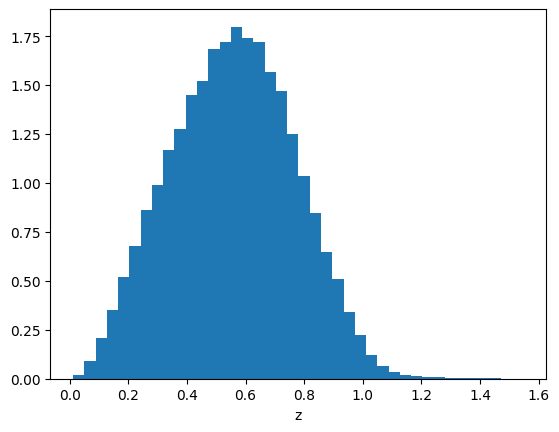

In [16]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True)
plt.xlabel("z")
plt.show()

In [17]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [18]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [19]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

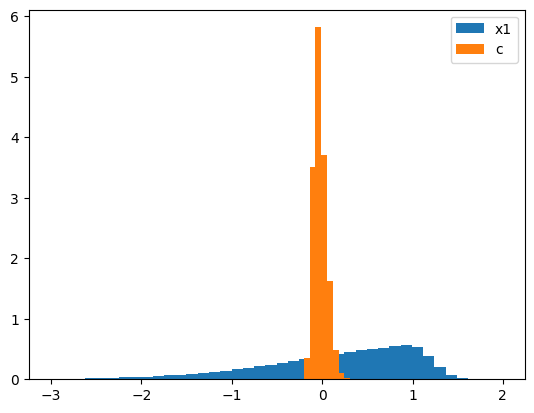

In [20]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [21]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    r_band_mask = lcs[0]['band'] == 'lsstr'
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)

    return lcs

In [22]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [23]:
# light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)
light_curve = simulate_ia(0.2, 20, get_x0(23.7568), -0.3504, 0.0744)

SNR: 1.5139008383311412


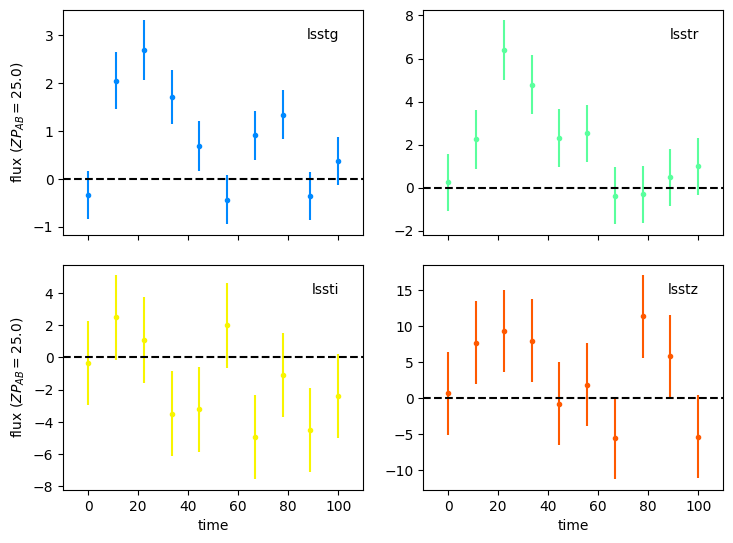

In [24]:
sncosmo.plot_lc(light_curve[0]);

In [25]:
light_curve[0]

time,band,flux,fluxerr,zp,zpsys
float64,str5,float64,float64,float64,str2
0.01,lsstg,-8.457202826775813,12.773689848346288,28.51,ab
11.12,lsstg,51.87814566441954,14.9742197187983,28.51,ab
22.23,lsstg,68.16037969383352,15.782640474864904,28.51,ab
33.339999999999996,lsstg,43.259726059248905,14.293189136712053,28.51,ab
44.449999999999996,lsstg,17.410621599854267,13.299937655221411,28.51,ab
55.559999999999995,lsstg,-11.157608710516795,13.02658166804703,28.51,ab
66.67,lsstg,22.988837544685268,12.950315190822547,28.51,ab
77.78,lsstg,33.856291453558775,12.909746611054114,28.51,ab
88.89,lsstg,-9.148294021684814,12.766151420403075,28.51,ab


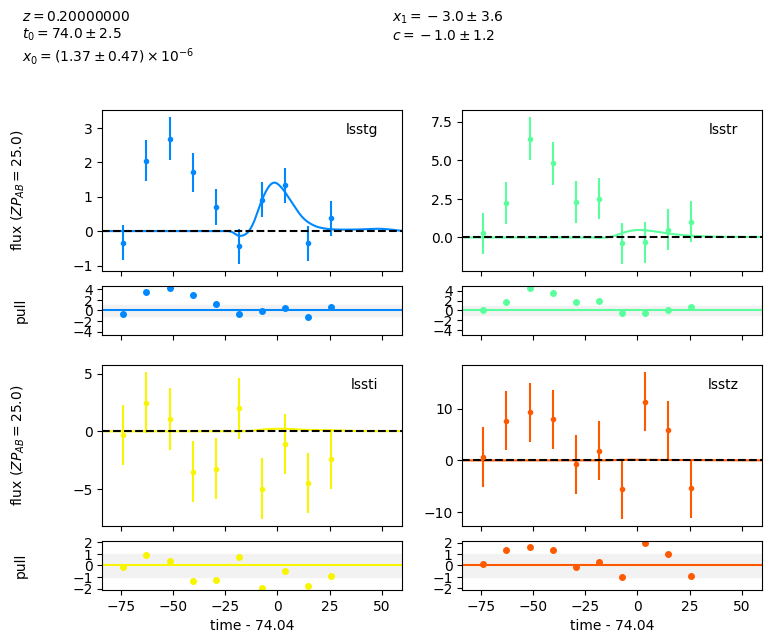

In [26]:
ia_result, ia_fitted_model = fit_ia(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

In [27]:
light_curve[0]

time,band,flux,fluxerr,zp,zpsys
float64,str5,float64,float64,float64,str2
0.01,lsstg,-8.457202826775813,12.773689848346288,28.51,ab
11.12,lsstg,51.87814566441954,14.9742197187983,28.51,ab
22.23,lsstg,68.16037969383352,15.782640474864904,28.51,ab
33.339999999999996,lsstg,43.259726059248905,14.293189136712053,28.51,ab
44.449999999999996,lsstg,17.410621599854267,13.299937655221411,28.51,ab
55.559999999999995,lsstg,-11.157608710516795,13.02658166804703,28.51,ab
66.67,lsstg,22.988837544685268,12.950315190822547,28.51,ab
77.78,lsstg,33.856291453558775,12.909746611054114,28.51,ab
88.89,lsstg,-9.148294021684814,12.766151420403075,28.51,ab


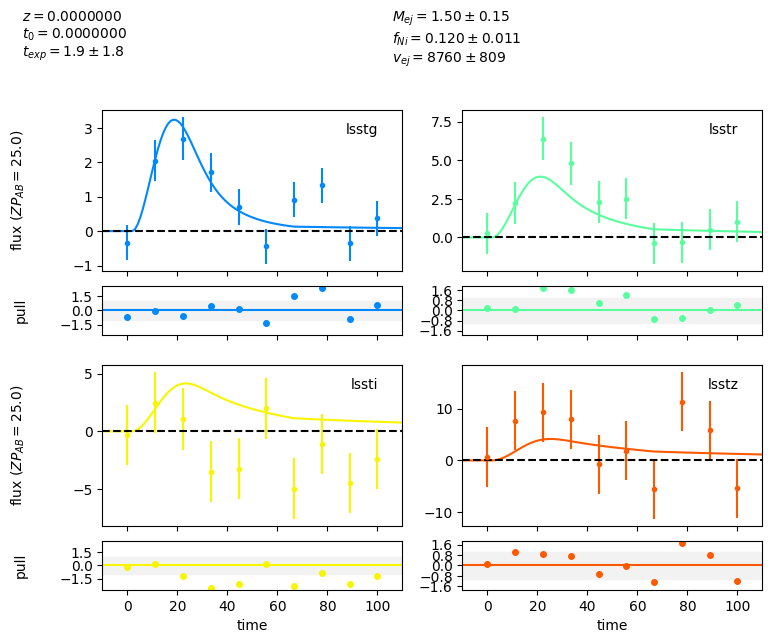

In [28]:
ibc_result, ibc_fitted_model = fit_ibc(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

SNR: 12.42262085146035


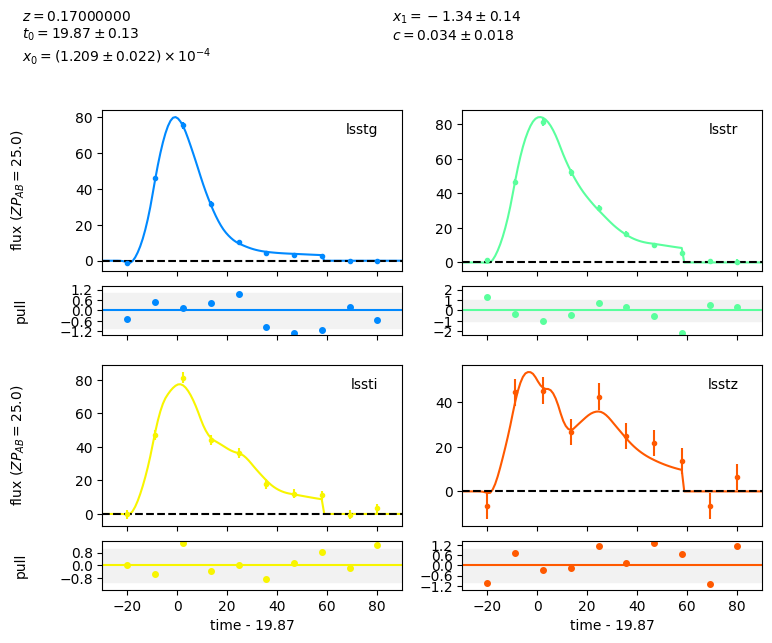

In [29]:
light_curve = simulate_ia(0.17, 20, get_x0(20.3969), -1.3166, 0.0048)
ia_result, ia_fitted_model = fit_ia(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

In [30]:
light_curve

[<Table length=40>
        time         band         flux             fluxerr          zp   zpsys
      float64        str5       float64            float64       float64  str2
 ------------------ ----- ------------------- ------------------ ------- -----
               0.01 lsstg  -31.37132156085848  13.65798744862391   28.51    ab
              11.12 lsstg   1162.838776059275 36.447100218467604   28.51    ab
              22.23 lsstg  1905.4361115677352  46.28366150694023   28.51    ab
 33.339999999999996 lsstg   805.2887995384291   31.5930003305212   28.51    ab
 44.449999999999996 lsstg  265.04553660623327  20.54100563575823   28.51    ab
 55.559999999999995 lsstg  109.80268173558494 17.157541835898574   28.51    ab
              66.67 lsstg     76.153880896006  16.23631365206525   28.51    ab
              77.78 lsstg  61.602515588590634 15.662595192969269   28.51    ab
              88.89 lsstg  2.4714556105385976 12.766151420403075   28.51    ab
              100.0 lsstg -7.2688

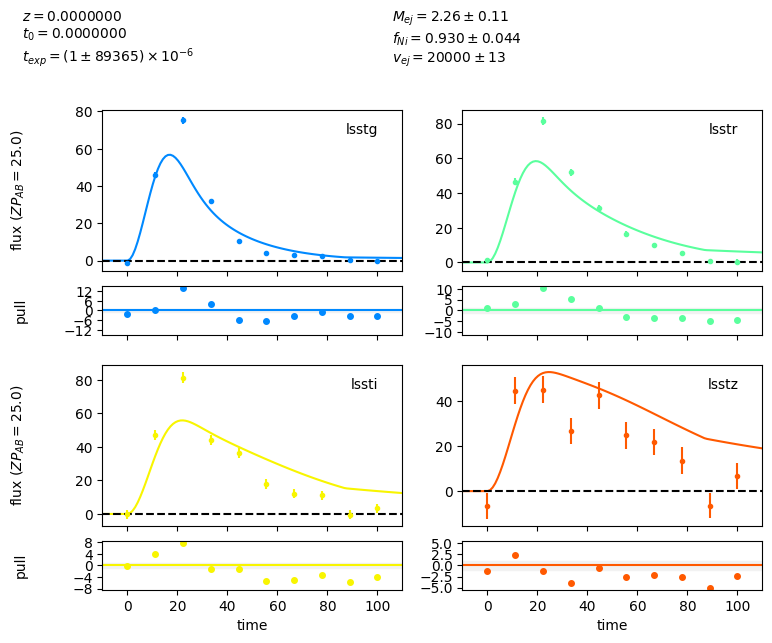

In [31]:
ibc_result, ibc_fitted_model = fit_ibc(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

SNR: 9.771332908326496


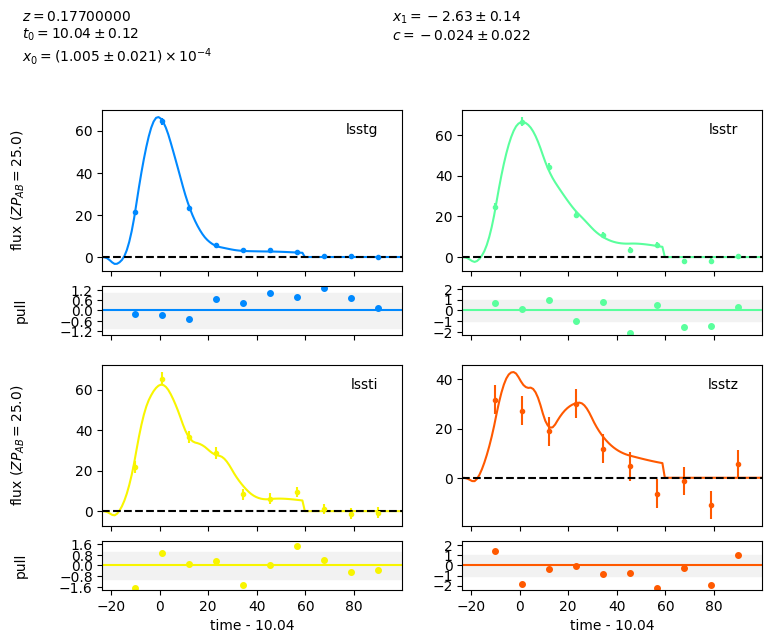

In [32]:
light_curve = simulate_ia(0.177, 10, get_x0(20.5669), -2.872, -0.0432)
ia_result, ia_fitted_model = fit_ia(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

Trying again...


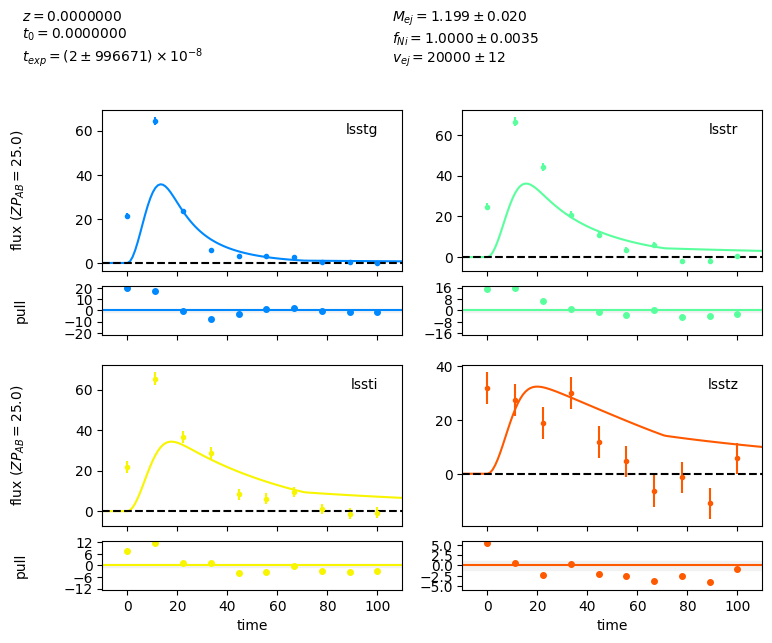

In [33]:
ibc_result, ibc_fitted_model = fit_ibc(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [34]:
num_to_fit = 100

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

# t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    # if true_z > 0.2:
    #     continue
    try:
        this_t0 = np.random.normal(14., 7.)
        print(true_z, this_t0)
        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("SNR too low:", peak_snr)
            continue

        result, model = fit_ia(true_z, lcs)

        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_t0'].append(this_t0)
        fits['true_x0'].append(x0)
        fits['true_x1'].append(x1)
        fits['true_c'].append(c)
        fits['fit_t0'].append(result_dict['t0'])
        fits['fit_x0'].append(result_dict['x0'])
        fits['fit_x1'].append(result_dict['x1'])
        fits['fit_c'].append(result_dict['c'])
    except:
        print(true_z)
        print("Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.624 27.911798526551927
SNR: 1.9155190990672906
SNR too low: 4.068977323326211
0.454 20.460107092465137
SNR: 4.100253454761214
SNR too low: 12.365139833035228
0.792 5.79137457507794
SNR: 0.8789362049127156
SNR too low: 2.1869360403990865
0.942 13.507929799350842
0.942
Did not work
0.904 15.979180016158642
SNR: 1.0767317482867402
SNR too low: 3.2573803969908908
0.844 21.256872477453214
SNR: 1.1115554756107995
SNR too low: 3.0372451631046773
1.146 6.145193604887775
1.146
Did not work
0.339 17.198027333397846
SNR: 7.231068578249193
SNR too low: 18.25815279645238
0.821 18.305739901365275
SNR: 1.2102789526593412
SNR too low: 4.017832316282172
0.456 22.484615537251013
SNR: 2.07191105564773
0.919 25.483031266171295
SNR: 1.0238743722452577
SNR too low: 2.774265860425931
0.455 14.961874437120702
SNR: 3.8809685305952164
SNR too low: 11.111727380644039
0.438 16.67818969341824
SNR: 2.187670475554451
0.747 6.769963809587228
SNR: 0.8026856757740715
SNR too low: 1.4141890238640409
0.706 10.512064522

Text(0, 0.5, 'Fit t0')

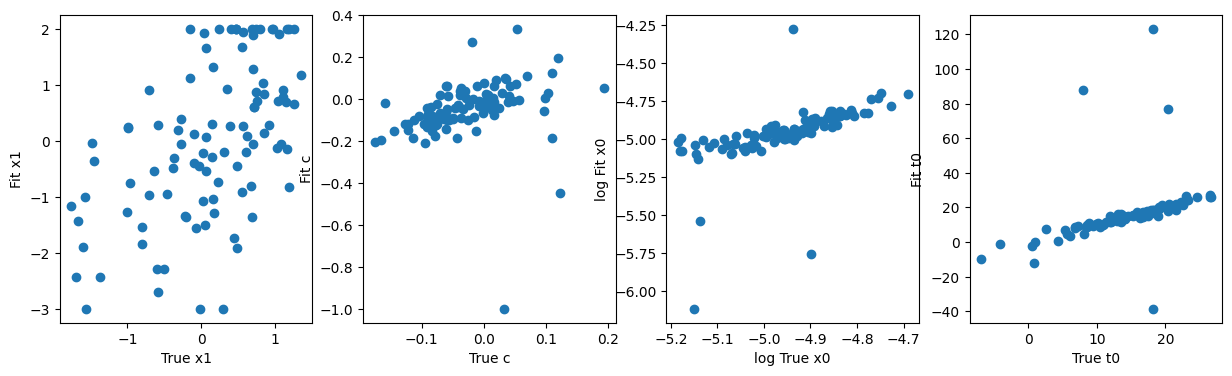

In [35]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")
ax[3].plot(fits['true_t0'], fits['fit_t0'], 'o')
ax[3].set_xlabel("True t0")
ax[3].set_ylabel("Fit t0")

In [36]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
            


In [37]:
SN('ia', {'z':0.6, 't0':20, 'x0':1e-5, 'x1':0.1, 'c':0.1}).true_class

'ia'

In [38]:
num_to_fit = 100

# t0 = 20

true_ia_sne = []

# fit true Ias as both
start = time.time()
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    # if true_z > 0.2:
    #     continue
    
    try:
        this_t0 = np.random.normal(14., 7.)
        print(true_z, this_t0)
        
        true_dict = {'z': true_z, 't0':this_t0, 'x0':x0, 'x1':x1, 'c':c}
        this_sn = SN('ia', true_dict)

        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("SNR too low:", peak_snr)
            continue

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)
        # print(sncosmo.flatten_result(ibc_result))
        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))

        true_ia_sne.append(this_sn)
    except Exception as e:
        print(e)

    if len(true_ia_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)


0.624 10.458734237253344
SNR: 1.2449621403819826
SNR too low: 2.3773724241721133
0.454 8.321224043564534
SNR: 4.033455447088212
SNR too low: 11.807258584773743
0.792 26.50224039047159
SNR: 1.2648883794444736
SNR too low: 3.4588031317358006
0.942 6.37384273875286
bandpass 'lsstg' [3866, .., 5670] outside spectral range [3884, .., 17866.4]
0.904 29.945498470325717
SNR: 0.7030399348267187
SNR too low: 1.121889871710726
0.844 14.291452928539348
SNR: 1.0372603035466508
SNR too low: 1.8061843511330502
1.146 8.972644964309717
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4292, .., 19743.2]
0.339 17.118120502780688
SNR: 7.54308261215598
SNR too low: 20.39886778348957
0.821 21.81388850278725
SNR: 1.4078082012006339
SNR too low: 2.7250803854831034
0.456 30.61572437019624
SNR: 2.2318580490575712
0.919 13.552204220894197
SNR: 0.937218450522494
SNR too low: 3.5289405487630354
0.455 12.837699116672884
SNR: 3.558918362540605
SNR too low: 10.388727175947269
0.438 15.344353623972669
SNR: 3.

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in add
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


`y` must contain only finite values.
1.043 3.0922030573820223
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4086, .., 18795.6]
1.088 5.883370830555833
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4176, .., 19209.6]
0.203 11.304411890345001
SNR: 13.412285532547008
SNR too low: 33.60709854935383
0.218 3.3604321315999837
SNR: 6.971324410355725
SNR too low: 22.536505684834065
1.049 15.54118496563808
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4098, .., 18850.8]
1.057 11.668309990715517
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4114, .., 18924.4]
1.206 18.518327316613846
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4412, .., 20295.2]
0.605 14.158187921344155
SNR: 2.430061118619814
1.118 15.31937139495563
bandpass 'lsstg' [3866, .., 5670] outside spectral range [4236, .., 19485.6]
0.818 8.51305297575777
SNR: 0.8278800191645066
SNR too low: 1.2400640084963424
0.442 14.128361427219318
SNR: 2.8685837625025377
1.243 18.086853323

In [39]:
true_ibc_sne = []

# Fit ibc as both
start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = (((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)).value
    
    # if true_z > 0.2 or vej > 20000:
    #     continue

    print(mej, fni, vej)

    
    try:
        this_texp = np.random.uniform(0., 7.)

        true_dict = {'z': true_z, 'texp': this_texp, 'mej':mej, 'fni':fni, 'vej':vej}
        this_sn = SN('ibc', true_dict)
        
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("SNR too low:", peak_snr)
            continue

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)

        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        true_ibc_sne.append(this_sn)

    except Exception as e:
        print(e)

    if len(true_ibc_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

4.046 0.0744 5748.580347068582
SNR: 0.6929932888746684
SNR too low: 1.842462131231877
6.1297 0.0565 6364.035693094851
SNR: 0.8880381785184717
SNR too low: 2.2665220844425886
9.8119 0.0849 6533.973178945778
SNR: 1.0466176014306998
SNR too low: 1.563627626725219
1.1125 0.0801 25485.974243842764
SNR: 0.92506972282623
SNR too low: 2.0926993383039343
2.0126 0.0448 13163.162093340352
SNR: 0.753577122638498
SNR too low: 1.6835422436937602
7.9452 0.1443 7627.722958615932
SNR: 0.5764702010905434
SNR too low: 0.6781598928744553
4.5871 0.0931 8095.727773637579
SNR: 1.6223923842512626
SNR too low: 3.8210542319023655
6.7104 0.1127 10015.866271790786
SNR: 0.8936279773130236
SNR too low: 1.607033673076604
6.2047 0.0218 6066.170004337498
SNR: 0.7987382181278505
SNR too low: 2.6488892136339404
8.4227 0.046 5106.1443009025215
SNR: 0.607618123498523
SNR too low: 1.0345666318549256
7.6562 0.0414 6873.203627108863
SNR: 0.7150121926948964
SNR too low: 0.915989185002753
6.0427 0.0457 5486.024578416964
SNR: 0

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:377: RuntimeWarning: overflow encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)


`y` must contain only finite values.
4.2109 0.0631 6175.507324299379
SNR: 0.7100374262556535
SNR too low: 2.466390856859015
3.3985 0.1212 5923.624229272563
SNR: 0.5528398699287628
SNR too low: 2.037392663749901
7.3382 0.0832 4170.759931741676
SNR: 1.1482173754089906
SNR too low: 2.6460529194816163
8.7431 0.0325 4310.246789794282
SNR: 0.9486734322371924
SNR too low: 2.484348502958562
2.824 0.0479 14640.617567530864
SNR: 0.35758791569034726
SNR too low: 1.229048376825094
4.5858 0.0604 9130.806415469538
SNR: 0.765582317574814
SNR too low: 0.7451002869227186
7.3948 0.0856 3970.628717539146
SNR: 0.6204267334742276
SNR too low: 0.8953272366947147
3.8873 0.1377 14446.917693984124
SNR: 0.9818437623850471
SNR too low: 2.454371055665203
6.3952 0.0928 8011.974479463983
SNR: 0.9546007266978641
SNR too low: 1.707599710511394
5.2169 0.0475 9635.149156554447
SNR: 0.500235600837741
SNR too low: 1.131305723452479
4.5871 0.0931 8095.727773637579
SNR: 0.7933117478716525
SNR too low: 1.8582360913472227
7.

In [40]:
np.savez("fitted_sne_100_091725.npz", ia=true_ia_sne, ibc=true_ibc_sne)

In [41]:
all_sne = true_ia_sne + true_ibc_sne
fit_x1 = [sn.ia_fit['x1'] for sn in all_sne]
fit_t0 = [sn.ia_fit['t0'] for sn in all_sne]
fit_c = [sn.ia_fit['c'] for sn in all_sne]
fit_x0 = [sn.ia_fit['x0'] for sn in all_sne]
fit_mej = [sn.ibc_fit['mej'] for sn in all_sne]
fit_fni = [sn.ibc_fit['fni'] for sn in all_sne]
fit_vej = [sn.ibc_fit['vej'] for sn in all_sne]

(array([ 2.,  7.,  5., 50., 73., 44.,  3.,  4.,  1., 11.]),
 array([-59.95941626, -41.55271652, -23.14601677,  -4.73931702,
         13.66738273,  32.07408248,  50.48078222,  68.88748197,
         87.29418172, 105.70088147, 124.10758121]),
 <BarContainer object of 10 artists>)

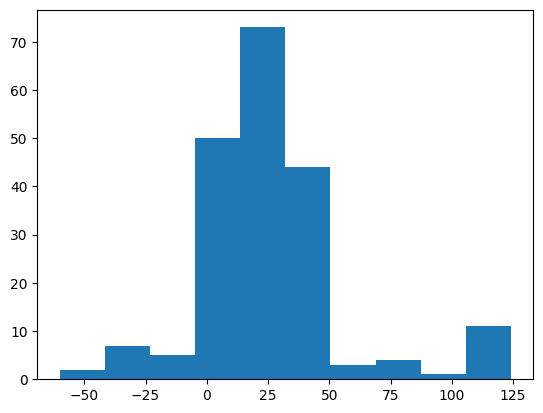

In [42]:
plt.hist(fit_t0)

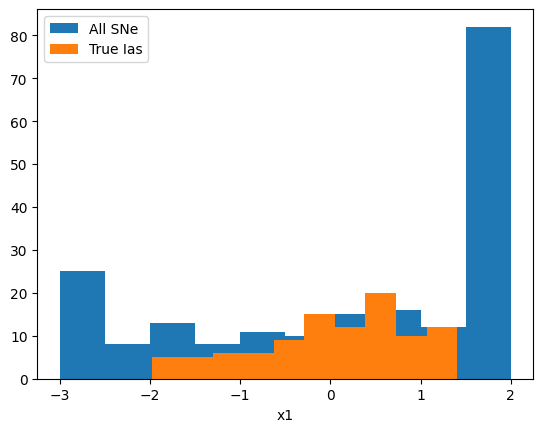

In [43]:
plt.hist(fit_x1, label="All SNe")
plt.hist([sn.true_params['x1'] for sn in true_ia_sne], label="True Ias")
plt.xlabel("x1")
plt.legend()

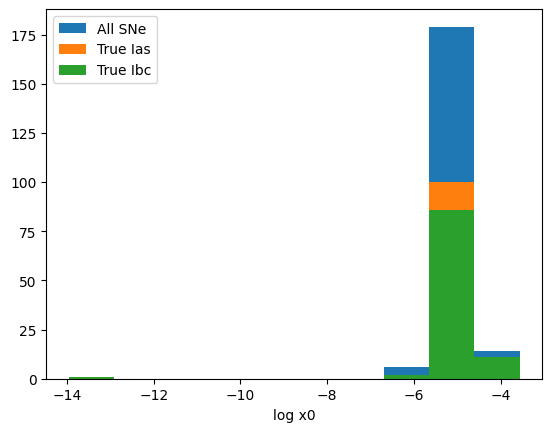

In [44]:
_, bins, _ = plt.hist(np.log10(fit_x0), label="All SNe")
plt.hist(np.log10([sn.true_params['x0'] for sn in true_ia_sne]), label="True Ias", bins=bins)
plt.hist(np.log10([sn.ia_fit['x0'] for sn in true_ibc_sne]), label="True Ibc", bins=bins)

plt.xlabel("log x0")
plt.legend()

In [45]:
ibc_mask = [sn in true_ibc_sne for sn in all_sne]

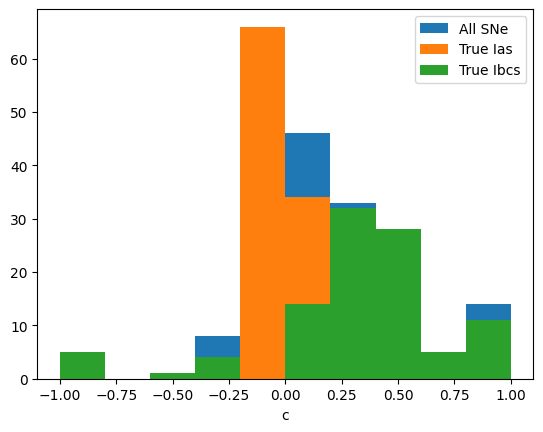

In [46]:
_, bins, _ = plt.hist(fit_c, label="All SNe")
plt.hist([sn.true_params['c'] for sn in true_ia_sne], label="True Ias", bins=bins)
plt.hist(fit_c[(len(fit_c)//2):len(fit_c)], label="True Ibcs", bins=bins)

plt.xlabel("c")
plt.legend()

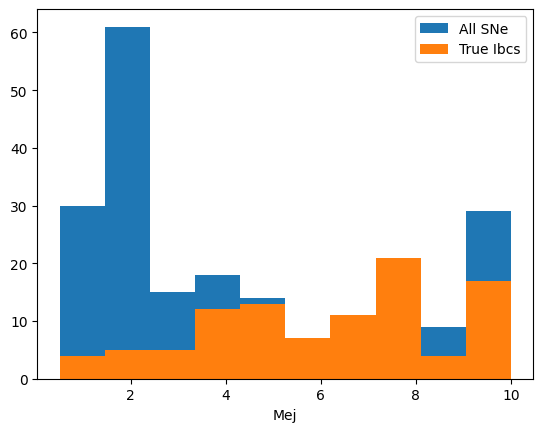

In [47]:
_, bins, _ = plt.hist(fit_mej, label="All SNe")
plt.hist([sn.true_params['mej'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

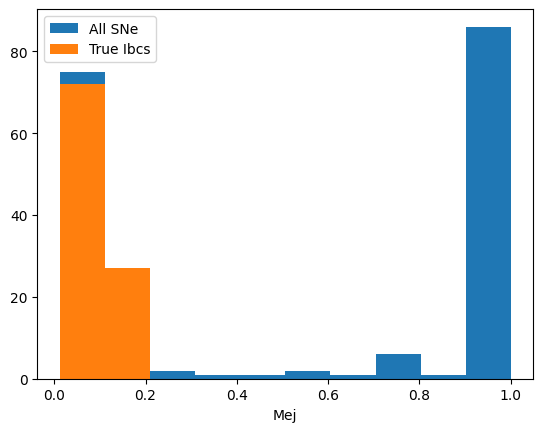

In [48]:
_, bins, _ = plt.hist(fit_fni, label="All SNe")
plt.hist([sn.true_params['fni'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

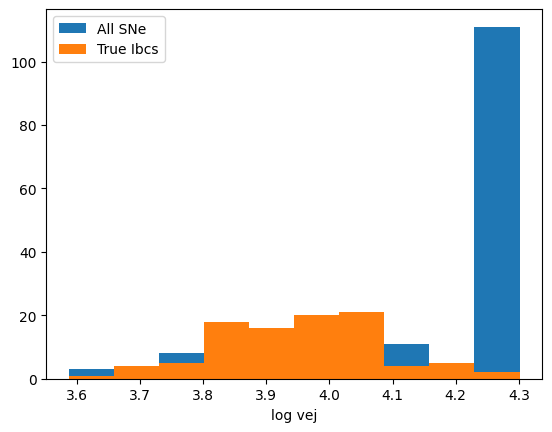

In [49]:
_, bins, _ = plt.hist(np.log10(fit_vej), label="All SNe")
plt.hist(np.log10([sn.true_params['vej'] for sn in true_ibc_sne]), label="True Ibcs", bins=bins)
plt.xlabel("log vej")
plt.legend()